In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# cv2.__version__ == '4.1.0' https://docs.opencv.org/4.1.0/

In [39]:
from glob import iglob
from os.path import basename, splitext

In [42]:
# load image examples into an array of tuples: (img: np.ndarray, img_name: str)
examples = []
for img_fname in iglob("i/*.png"):
    img_name = splitext(basename(img_fname))[0]
    img = cv2.imread(img_fname, cv2.IMREAD_GRAYSCALE)
    examples.append((img, img_name))

In [44]:
# shows a grayscale image without changing it's pixel values for display
def show_grayscale(img_tuple):
    img, img_name = img_tuple
    plt.title(img_name)
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)

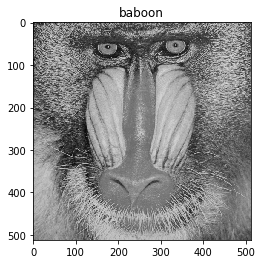

In [49]:
test_img = examples[0] # baboon
show_grayscale(test_img)

## 1.1 Transformação de Intensidade

## $(i)$ Negativo da imagem

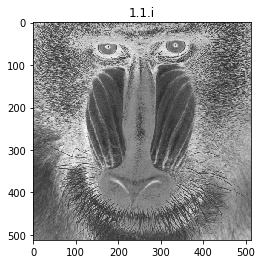

In [50]:
img = 255 - test_img[0] # [0, 255] -> [255, 0]
show_grayscale((img, '1.1.i'))

## $(ii)$ Converter o intervalo de intensidades para $[100, 200]$

min = 0, max = 230
min = 100.0, max = 190.19607843137254


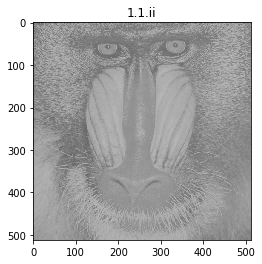

In [61]:
img = 100 * (test_img[0] / 255.0) + 100 # [0, 255] -> [100, 200]
show_grayscale((img, '1.1.ii'))
print(f"min = {np.min(test_img[0])}, max = {np.max(test_img[0])}")
print(f"min = {np.min(img)}, max = {np.max(img)}")